## Analysis of Digital Learning During Covid 19 (s2 2023)

In [41]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
!pip install altair
import altair as alt
%matplotlib inline

# Purposes
The portfolio 4 will focus on the data analysis to figure out the digital learning trends and its effectiveness during the COVID-19 Pandemic. The datasource is from https://www.kaggle.com/competitions/learnplatform-covid19-impact-on-digital-learning/data, which consists of 3 main files: products_info, districts_info, and engagement data. For this analysis, it will apply logistics regression model since most of variables are objects, therefore, logistics regression model will be suitable.Linear Regression modell will also be applied in this analysi  fo the prediction of a continuous target variabless. 

1. The header of products_info.csv
   
LP ID | URL | Product Name | Provider/Company Name | Sector(s) | Primary Essential Function 

- LP ID: The unique identifier of the .product
  
- URL: Web Link to the specific product
  
- Product Name: Name of the specific product
  
- Provider/Company Name: Name of the product provider
  
- Sector(s): Sector of education where the product is used
  
- Primary Essential Function: The basic function of the product. There are two layers of labels here. Products are first labeled as one of these three categories: LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations. Each of these categories have multiple sub-categories with which the prod.ucts were labeled

2. The header of districts_info.csv
   
district_id | state | locale | pct_black/hispanic | pct_free/reduced | county_connections._ratio | pp_total_raw

- district_id: The unique identifier of the school district

- state: The state where the district resides in.

- locale: NCES locale classification that categorizes U.S. territory into four types of areas: City, Suburban, Town, and Rural.

- pct_black/hispanic: Percentage of students in the districts identified as Black or Hispanic based on 2018-19 NCES data.

- pct_free/reduced: Percentage of students in the districts eligible for free or reduced-price lunch based on 2018-19 NCES data.

- county_connections_ratio: `ratio` (residential fixed high-speed connections over 200 kbps in at least one direction/households) based on the county level data from FCC From 477 (December 2018 version). 

- pp_total_raw: Per-pupil total expenditure (sum of local and federal expenditure) from Edunomics Lab's National Education Resource Database on Schools (NERD$) project. 

3. The header of engagement data.csv
   
time | lp_id | pct_access | engagement_index | districtid

- time: date in "YYYY-MM-DD"
  
- lp_id: The unique identifier of the product
  
- pct_access: Percentage of studens in the district have at least one page-load event of a given product and on a given day
  
- engagement_index: Total page-load events per one thousday students of a given product and on a given day
lisation of the data or results
 data or results

In [2]:
product = pd.read_csv('products_info.csv')
product.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms


In [3]:
district = pd.read_csv('districts_info.csv')
district.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,NaN,NaN,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,NaN,NaN,NaN,NaN,NaN,NaN
4,2238,NaN,NaN,NaN,NaN,NaN,NaN


### Explanation 
I define a function to extract all engagement data files and merge into one CSV file. 

In [4]:
def engagement_data_extract(file_path):    
    
    dir_path = os.path.dirname(file_path)
    ap = []
    for root, dirs, files in os.walk(dir_path):
        for file in files: 
            if file.endswith('.csv'):

                df = pd.read_csv(root+'/'+str(file), index_col=None, header=0)
                district_id = file.split(".")[0]
                df["district_id"] = district_id
                ap.append(df)
        engagement = pd.concat(ap)
        engagement = engagement.reset_index(drop=True)
    return engagement

In [5]:
engagement = engagement_data_extract(
    "./learnplatform-covid19-impact-on-digital-learning/engagement_data/"
    )
engagement.head()

,time,lp_id,pct_access,engagement_index,district_id
0,2020-01-01,93690.0,0.00,NaN,1000
1,2020-01-01,17941.0,0.03,0.90,1000
2,2020-01-01,65358.0,0.03,1.20,1000
3,2020-01-01,98265.0,0.57,37.79,1000
4,2020-01-01,59257.0,0.00,NaN,1000


For district dataset, pct_black/hispanic and pct_free/reduced features provide a range, which is quite difficult for the analysis. Therefore, the conductor calculate the mean of that range (for example: 0, 0.2 will generate the result equal 0.1). Finally, all "NA" values will be dropped. 

In [6]:
district.dropna(inplace = True)
for i in ['pct_black/hispanic', 'pct_free/reduced','county_connections_ratio']:
    district[i] = district[i].apply(lambda x: float(str(x).split(',')[0][1:])+0.1)

district['pp_total_raw'] = district['pp_total_raw'].apply(lambda x: int(x.split(',')[0][1:]) + 1000)
district.drop('county_connections_ratio', axis = 1, inplace = True)

district.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,pp_total_raw
0,8815,Illinois,Suburb,0.1,0.1,15000
2,4921,Utah,Suburb,0.1,0.3,7000
5,5987,Wisconsin,Suburb,0.1,0.1,11000
6,3710,Utah,Suburb,0.1,0.5,7000
7,7177,North Carolina,Suburb,0.3,0.3,9000


Noticing the relationship between all three dataset, the conductor decided to merge all of them into 1 dataframe, and the similar features are lp_id and district_id. 

In [7]:
engagement["district_id"] = engagement["district_id"].astype(str).astype(int)

data = product.merge(
                                   engagement,
                                   left_on='LP ID', 
                                   right_on='lp_id'
                                   ).merge(
                                    district,
                                    left_on='district_id',
                                    right_on='district_id')
data.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,pp_total_raw
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-01-13,13117.0,0.04,0.80,1052,Illinois,Suburb,0.3,0.3,17000
1,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-02-04,13117.0,0.04,0.40,1052,Illinois,Suburb,0.3,0.3,17000
2,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-02-06,13117.0,0.12,7.90,1052,Illinois,Suburb,0.3,0.3,17000
3,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-02-07,13117.0,0.04,1.18,1052,Illinois,Suburb,0.3,0.3,17000
4,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-02-10,13117.0,0.08,8.64,1052,Illinois,Suburb,0.3,0.3,17000


Eventually, all "NA" values of the dataframe will be dropped out. 

In [8]:
NA = pd.DataFrame(data=[data.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (data.isna().sum()/data.shape[0]*100).tolist()]], 
            columns=data.columns, index=['NA Count', 'NA Percent']).transpose().\
            sort_values(by='NA Count',ascending=False)
NA.style.background_gradient(cmap="vlag", subset=['NA Count'])

,NA Count,NA Percent
engagement_index,888643,18.99%
Sector(s),205263,4.39%
Primary Essential Function,205263,4.39%
pct_access,2393,0.05%
LP ID,0,0.00%
URL,0,0.00%
Product Name,0,0.00%
Provider/Company Name,0,0.00%
time,0,0.00%
lp_id,0,0.00%


In [9]:
data_clean= data.dropna()

In [10]:
NA = pd.DataFrame(data=[data_clean.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (data_clean.isna().sum()/data_clean.shape[0]*100).tolist()]], 
            columns=data_clean.columns, index=['NA Count', 'NA Percent']).transpose().\
            sort_values(by='NA Count',ascending=False)
NA.style.background_gradient(cmap="vlag", subset=['NA Count'])

,NA Count,NA Percent
LP ID,0,0.00%
URL,0,0.00%
Product Name,0,0.00%
Provider/Company Name,0,0.00%
Sector(s),0,0.00%
Primary Essential Function,0,0.00%
time,0,0.00%
lp_id,0,0.00%
pct_access,0,0.00%
engagement_index,0,0.00%


In [11]:
data_clean.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function,time,lp_id,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,pp_total_raw
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-01-13,13117.0,0.04,0.80,1052,Illinois,Suburb,0.3,0.3,17000
1,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-02-04,13117.0,0.04,0.40,1052,Illinois,Suburb,0.3,0.3,17000
2,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-02-06,13117.0,0.12,7.90,1052,Illinois,Suburb,0.3,0.3,17000
3,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-02-07,13117.0,0.04,1.18,1052,Illinois,Suburb,0.3,0.3,17000
4,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms,2020-02-10,13117.0,0.08,8.64,1052,Illinois,Suburb,0.3,0.3,17000


In [12]:
data_clean.dtypes

LP ID                           int64
URL                            object
Product Name                   object
Provider/Company Name          object
Sector(s)                      object
Primary Essential Function     object
time                           object
lp_id                         float64
pct_access                    float64
engagement_index              float64
district_id                     int32
state                          object
locale                         object
pct_black/hispanic            float64
pct_free/reduced              float64
pp_total_raw                    int64
dtype: object

In [13]:
ord_enc = OrdinalEncoder()
columns_to_encode = ['URL', 'Product Name', 'Provider/Company Name', 'Sector(s)', 'Primary Essential Function', 'state', 'locale',]
for column in columns_to_encode:
    data_clean[column] = ord_enc.fit_transform(data_clean[[column]])

drop = ['time', 'lp_id']
data_clean = data_clean.drop(drop, axis = 1)

data_clean.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22140\1295572409.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[column] = ord_enc.fit_transform(data_clean[[column]])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22140\1295572409.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[column] = ord_enc.fit_transform(data_clean[[column]])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22140\1295572409.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function,pct_access,engagement_index,district_id,state,locale,pct_black/hispanic,pct_free/reduced,pp_total_raw
0,13117,332.0,273.0,220.0,2.0,10.0,0.04,0.80,1052,1.0,2.0,0.3,0.3,17000
1,13117,332.0,273.0,220.0,2.0,10.0,0.04,0.40,1052,1.0,2.0,0.3,0.3,17000
2,13117,332.0,273.0,220.0,2.0,10.0,0.12,7.90,1052,1.0,2.0,0.3,0.3,17000
3,13117,332.0,273.0,220.0,2.0,10.0,0.04,1.18,1052,1.0,2.0,0.3,0.3,17000
4,13117,332.0,273.0,220.0,2.0,10.0,0.08,8.64,1052,1.0,2.0,0.3,0.3,17000


In [14]:
data_clean.dtypes

LP ID                           int64
URL                           float64
Product Name                  float64
Provider/Company Name         float64
Sector(s)                     float64
Primary Essential Function    float64
pct_access                    float64
engagement_index              float64
district_id                     int32
state                         float64
locale                        float64
pct_black/hispanic            float64
pct_free/reduced              float64
pp_total_raw                    int64
dtype: object

In [15]:
data_clean['locale'] = data_clean['locale'].astype(int)
data_clean['state'] = data_clean['state'].astype(int)

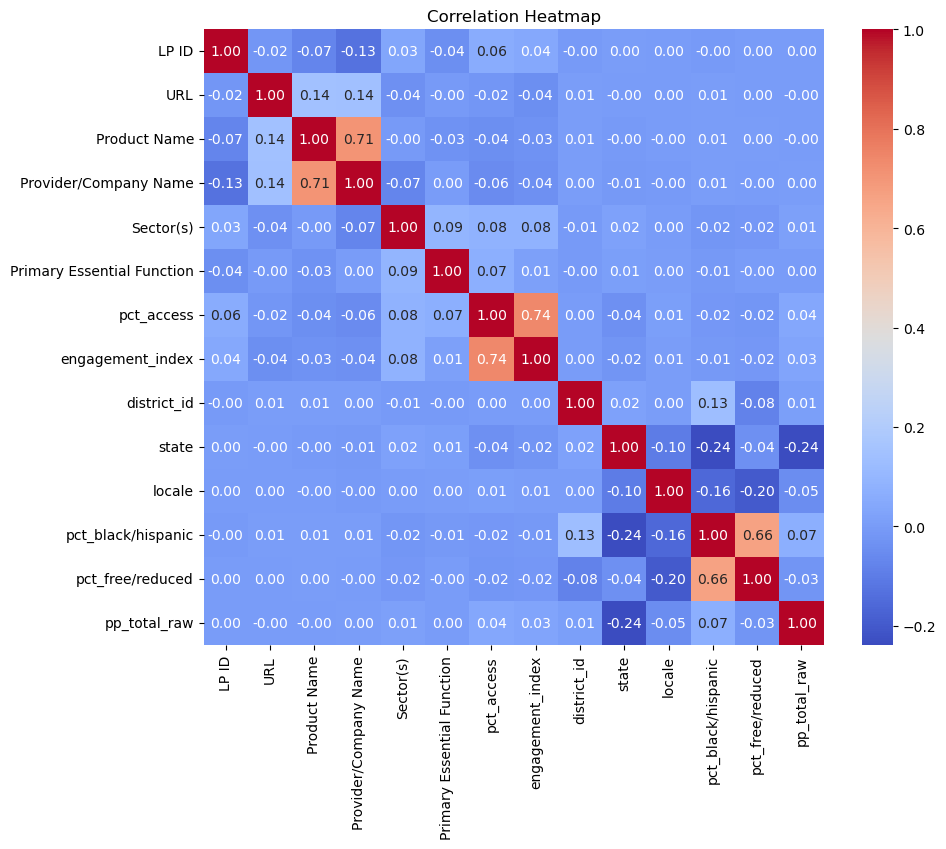

In [16]:
cor_matrix = data_clean.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Linear Regression Model

For the prediction of Linear Regression Model, the analysis will choose pct_black/hispanic and pct_free/reduced features since they have the highest correlation and also not a categorical values in the dataframe. 

In [17]:
X = data_clean[['pct_black/hispanic']]
y = data_clean['pct_free/reduced']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=142)
print(X_train.shape, X_test.shape)

(2903219, 1) (725805, 1)


In [19]:
model = LinearRegression()

In [20]:
model.fit(X_train, y_train)

LinearRegression()

In [21]:
predicted = model.predict(X_test)

In [22]:
mse = mean_squared_error(y_test, predicted)
rmse = sqrt(mse)
r2 = r2_score(y_test, predicted)

print("Model:")
print("MSE:", mse)
print("Root MSE", rmse)
print("R Squared:", r2)

Model:
MSE: 0.022549600761024736
Root MSE 0.15016524485054702
R Squared: 0.4409906167490474


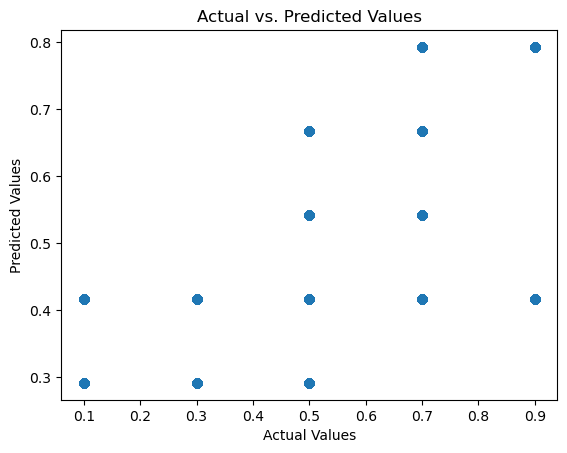

In [23]:
plt.scatter(y_test, predicted)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

After apply Linear Regression Model, the analysis will undergo the Polynomial regression for improvement 

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)  

model_poly = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model_poly.fit(X_poly, y)

y_pred = model_poly.predict(X_poly)

mse_poly = mean_squared_error(y, y_pred)
print("MSE - Polynomial:", mse_poly)

r2_poly = r2_score(y, y_pred)
print("R-squared - Polynomial:", r2_poly)

MSE - Polynomial: 0.02173167716829622
R-squared - Polynomial: 0.4609364155594361


# Analysis: 
An MSE of 0.0225 means, on average, the squared difference between the actual pct_free/reduced values and the values predicted by your model is 0.0225. A lower MSE indicates better model performance.

RMSE of 0.1502 indicates that, on average, the model's predictions deviate from the actual values by approximately 0.1502 units. A lower RMSE is preferred as it signifies smaller prediction errors.

In this model, it suggests that pct_black/hispanic is a useful predictor for estimating pct_free/reduced with a positive correlation of 0.66.

An R-squared (R²) value of 0.4409 means that approximately 44.09% of the variance in the target variable is explained by the independent variables included in your linear regression model. 

The polynomial model appears to perform slightly better than the original linear model. The lower MSE suggests improved prediction accuracy, and the higher R-squared suggests a better fit to the data. However, the differences between the two models are relatively small.

In summary, the linear regression model is able to predict pct_free/reduced based on pct_black/hispanic with a reasonably low MSE and RMSE, indicating a relatively good fit.

## KNN Model

In [24]:
X_1 = data_clean[['state', "Sector(s)", "LP ID", 'Primary Essential Function', 'locale']]
y_1 = data_clean[['Product Name']]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, train_size = 0.8, random_state= 999)
print(X_train_1.shape, X_test_1.shape)
y_train_1 = y_train_1.values.ravel()
y_test_1 = y_test_1.values.ravel()

(2903219, 5) (725805, 5)


In [26]:
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_1, y_train_1)

#Predict data
y_pred_knn = knn.predict(X_test_1)
accuracy_knn = accuracy_score (y_test_1, y_pred_knn)
print("Testing Accuracy: ", accuracy_knn)

Testing Accuracy:  1.0


In [27]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train_1, y_train_1)

#Predict data
y_pred_knn = knn.predict(X_test_1)
accuracy_knn = accuracy_score (y_test_1, y_pred_knn)
print("Testing Accuracy: ", accuracy_knn)

Testing Accuracy:  1.0


# Analysis: 

The analysis obtains a testing accuracy of 1.0 (100%) for both n_neighbors = 10 and n_neighbors = 100 with a K-Nearest Neighbors (KNN) classifier, implying that this KNN model is achieving perfect accuracy on the test data for the given hyperparameter settings. This might be due to overfitting situation. 

# Visualisation: 

In [45]:
alt.Chart(district).mark_bar(
    cornerRadiusTopLeft=3,
    cornerRadiusTopRight=3).encode(
    x=alt.X('state:O',sort=alt.EncodingSortField(field="state", op="count", order='descending')),
    y=alt.Y('count(state):O'),
    tooltip='count(state):O',
    color=alt.Color('state:O',
                    sort=alt.EncodingSortField(field="state",op="count", order='descending'),
                    legend=None,scale=alt.Scale(scheme = 'blues')) 
    ).properties(title='Number of Districts per states')

alt.Chart(...)

The fact that the data set contains more districts from Utah and Illinois than any other state might imply that these states have a more significant representation of using digital learning programs during the COVID-19 pandemic. It could also present regional variances, implying that there might be challenges in integrating digital learning environments in some States that have low occurrences (e.g. Florida, and Minnesota). This graph also recommends that more interventions or policy decisions should be allocated to low-income states to equally distribute digital learning to the communities.